# Searching major star catalogs and Simbad by position or name with `vo_conesearch`

## Authors
P. L. Lim

## Learning Goals
* Perform a cone search around M31 using a web service.
* Write the result out to a LaTeX table.
* Perform a SIMBAD query using the cone search result.
* Extract metadata from the cone search catalog.
* Sort cone search results by angular distance.
* Search multiple cone search services at once (synchronously and asynchronously).
* Estimate the run time of a cone search.

## Keywords
astroquery, table, coordinates, units, vo_conesearch, LaTex, SIMBAD, matplotlib

## Summary
This tutorial desmonstrates the [Cone Search](http://astroquery.readthedocs.io/en/latest/vo_conesearch/vo_conesearch.html) subpackage, which allows you to query a catalog of astronomical sources and obtain those that lie within a cone of a given radius around the given position. 

### Imports

In [1]:
# Python standard library
import time
import warnings

# Third-party software
import numpy as np

# Astropy
from astropy import coordinates as coord
from astropy import units as u
from astropy.table import Table

# Astroquery. This tutorial requires 0.3.5 or greater.
import astroquery
from astroquery.simbad import Simbad
from astroquery.vo_conesearch import conf, conesearch, vos_catalog

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

If you are running an older version of `astroquery`, you might need to set `vos_baseurl` yourself, as follows.

In [2]:
from astropy.utils import minversion

if not minversion(astroquery, '0.3.10'):
    conf.vos_baseurl = 'https://astroconda.org/aux/vo_databases/'

To start, it might be useful to list the available Cone Search catalogs first. By default, catalogs that pass nightly validation are included. Validation is hosted by Space Telescope Science Institute (STScI).

In [3]:
conesearch.list_catalogs()

['Guide Star Catalog 2.3 Cone Search 1',
 'The HST Guide Star Catalog, Version 1.1 1',
 'The HST Guide Star Catalog, Version 1.2 1',
 'The HST Guide Star Catalog, Version GSC-ACT 1',
 'The PMM USNO-A1.0 Catalogue 1',
 'The USNO-A2.0 Catalogue 1']

Next, let's pick an astronomical object of interest. For example, M31.

In [4]:
c = coord.SkyCoord.from_name('M31', frame='icrs')
print(c)

<SkyCoord (ICRS): (ra, dec) in deg
    (10.68470833, 41.26875)>


By default, a basic Cone Search goes through the list of catalogs and *stops* at the first one that returns non-empty VO table. Let's search for objects within 0.1 degree around M31. You will see a lot of warnings that were generated by VO table parser but ignored by Cone Search service validator. VO compliance enforced by Cone Search providers is beyond the control of `astroquery.vo_conesearch` package.

The result is an [Astropy table](http://astropy.readthedocs.io/en/stable/table/index.html).

In [5]:
result = conesearch.conesearch(c, 0.1 * u.degree)

Trying http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&


In [6]:
print('First non-empty table returned by', result.url)
print('Number of rows is', len(result))

First non-empty table returned by http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23
Number of rows is 4028


In [7]:
print(result)

    objID           gsc2ID      gsc1ID ... multipleFlag compassGSC2id   Mag  
                                       ...                              mag  
-------------- ---------------- ------ ... ------------ ------------- -------
23323175812944 00424433+4116085        ...            0 6453800072293   9.453
23323175812948 00424403+4116069        ...            0 6453800072297   9.321
23323175812933 00424455+4116103        ...            0 6453800072282  10.773
23323175812939 00424464+4116092        ...            0 6453800072288   9.299
23323175812930 00424403+4116108        ...            0 6453800072279  11.507
23323175812931 00424464+4116106        ...            0 6453800072280   9.399
23323175812973 00424446+4116016        ...            0 6453800072322   12.07
23323175812966 00424398+4116028        ...            0 6453800072315  12.136
23323175812979 00424420+4116009        ...            0 6453800072328  10.065
23323175812958 00424377+4116045        ...            0 64538000

This table can be manipulated like any other Astropy table; e.g., re-write the table into LaTeX format.

In [8]:
result.write('my_result.tex', format='ascii.latex', overwrite=True)

You can now use your favorite text editor to open the `my_result.tex` file, but here, we are going to read it back into another Astropy table.

Note that the extra `data_start=4` option is necessary due to the non-roundtripping nature of LaTeX reader/writer (see [astropy issue 5205](https://github.com/astropy/astropy/issues/5205)).

In [9]:
result_tex = Table.read('my_result.tex', format='ascii.latex', data_start=4)
print(result_tex)

    objID           gsc2ID      gsc1ID ... multipleFlag compassGSC2id   Mag  
-------------- ---------------- ------ ... ------------ ------------- -------
23323175812944 00424433+4116085     -- ...            0 6453800072293   9.453
23323175812948 00424403+4116069     -- ...            0 6453800072297   9.321
23323175812933 00424455+4116103     -- ...            0 6453800072282  10.773
23323175812939 00424464+4116092     -- ...            0 6453800072288   9.299
23323175812930 00424403+4116108     -- ...            0 6453800072279  11.507
23323175812931 00424464+4116106     -- ...            0 6453800072280   9.399
23323175812973 00424446+4116016     -- ...            0 6453800072322   12.07
23323175812966 00424398+4116028     -- ...            0 6453800072315  12.136
23323175812979 00424420+4116009     -- ...            0 6453800072328  10.065
23323175812958 00424377+4116045     -- ...            0 6453800072307  12.446
           ...              ...    ... ...          ...         

Cone Search results can also be used in conjuction with other types of queries.
For example, you can query SIMBAD for the first entry in your result above.

In [10]:
# Due to the unpredictability of external services,
# The first successful query result (above) might differ
# from run to run.
#
# CHANGE THESE VALUES to the appropriate RA and DEC
# column names you see above, if necessary.
# These are for http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&
ra_colname = 'ra'
dec_colname = 'dec'

In [11]:
# Don't run this cell if column names above are invalid.
if ra_colname in result.colnames and dec_colname in result.colnames:
    row = result[0]
    simbad_obj = coord.SkyCoord(ra=row[ra_colname]*u.deg, dec=row[dec_colname]*u.deg)
    print('Searching SIMBAD for\n{}\n'.format(simbad_obj))
    simbad_result = Simbad.query_region(simbad_obj, radius=5*u.arcsec)
    print(simbad_result)
else:
    print('{} or {} not in search results. Choose from: {}'.format(
        ra_colname, dec_colname, ' '.join(result.colnames)))

Searching SIMBAD for
<SkyCoord (ICRS): (ra, dec) in deg
    (10.684737, 41.269035)>



            MAIN_ID                  RA      ... SCRIPT_NUMBER_ID
                                  "h:m:s"    ...                 
------------------------------- ------------ ... ----------------
               NAME P2B Cluster  00 42 44.34 ...                1
                     [LFG93] P3  00 42 44.34 ...                1
                      NAME M31*  00 42 44.33 ...                1
    [K2002] J004244.35+411608.9 00 42 44.351 ...                1
                  [HPH2013] 165  00 42 44.34 ...                1
                  [HPH2013] 164  00 42 44.30 ...                1
                     [LFG93] P1  00 42 44.37 ...                1
    [KPM2002] G121.1741-21.5730  00 42 44.27 ...                1
                  [O2006] QSS 8 00 42 44.365 ...                1
                  [HPH2013] 167  00 42 44.36 ...                1
                            ...          ... ...              ...
        CXOGMP J004244.2+411608   00 42 44.2 ...                1
          

Now back to Cone Search... You can extract metadata of this Cone Search catalog.

In [12]:
my_db = vos_catalog.get_remote_catalog_db(conf.conesearch_dbname)
my_cat = my_db.get_catalog_by_url(result.url + '&')
print(my_cat.dumps())

{
    "authenticated_only": 0,
    "cap_description": "",
    "cap_index": 1,
    "cap_type": "conesearch",
    "content_level": "research",
    "content_type": "catalog",
    "created": "12/4/2008 3:29:11 PM",
    "creator_seq": "",
    "duplicatesIgnored": 1,
    "intf_index": 1,
    "intf_role": "std",
    "intf_type": "vs:paramhttp",
    "ivoid": "ivo://archive.stsci.edu/gsc/gsc2.3",
    "mirror_url": "",
    "query_type": "",
    "reference_url": "http://gsss.stsci.edu/Catalogs/GSC/GSC2/GSC2.htm",
    "region_of_regard": NaN,
    "res_description": "The Guide Star Catalog II (GSC-II) is an all-sky optical catalog based on 1\" resolution scans of the photographic Sky Survey plates, at two epochs and three bandpasses, from the Palomar and UK Schmidt telescopes. This all-sky catalog will ultimately contains positions, proper motions, classifications, and magnitudes in multiple bandpasses for almost a billion objects down to approximately Jpg=21, Fpg=20. The GSC-II is currently used f

If you have a favorite catalog in mind, you can also perform Cone Search only on that catalog. A list of available catalogs can be obtained by calling `conesearch.list_catalogs()`, as mentioned above.

In [13]:
try:
    result = conesearch.conesearch(
        c, 0.1 * u.degree, catalog_db='The USNO-A2.0 Catalogue (Monet+ 1998) 1')
except Exception as e:  
    # We provide a cached version of the result table in case the query fails 
    # due to an intermittent server-side issue, or if you do not have an 
    # internet connection
    result = Table.read('usno-A2-result.fits')

In [14]:
print('Number of rows is', len(result))

Number of rows is 3


Let's explore the 3 rows of astronomical objects found within 0.1 degree of M31 in the given catalog and sort them by increasing distance. For this example, the VO table has several columns that might include:

* `_r` = Angular distance (in degrees) between object and M31
* `USNO-A2.0` = Catalog ID of the object
* `RAJ2000` = Right ascension of the object (epoch=J2000)
* `DEJ2000` = Declination of the object (epoch=J2000)

Note that column names, meanings, order, etc. might vary from catalog to catalog.

In [15]:
col_names = result.colnames
print(col_names)

['_r', 'USNO-A2.0', 'RAJ2000', 'DEJ2000', 'ACTflag', 'Mflag', 'Bmag', 'Rmag', 'Epoch']


In [16]:
# Before sort
print(result)

   _r      USNO-A2.0    RAJ2000    DEJ2000   ACTflag Mflag Bmag Rmag  Epoch  
  deg                     deg        deg                   mag  mag     yr   
-------- ------------- ---------- ---------- ------- ----- ---- ---- --------
0.094265 1275-00425574  10.595878  41.335328      --    -- 19.8 17.4 1953.773
0.098040 1275-00427192  10.639945  41.360845      --    -- 19.4 18.4 1953.773
0.063280 1275-00429939  10.712834  41.209109       A    -- 99.9 11.2       --


In [17]:
# After sort
result.sort('_r')
print(result)

   _r      USNO-A2.0    RAJ2000    DEJ2000   ACTflag Mflag Bmag Rmag  Epoch  
  deg                     deg        deg                   mag  mag     yr   
-------- ------------- ---------- ---------- ------- ----- ---- ---- --------
0.063280 1275-00429939  10.712834  41.209109       A       99.9 11.2       --
0.094265 1275-00425574  10.595878  41.335328               19.8 17.4 1953.773
0.098040 1275-00427192  10.639945  41.360845               19.4 18.4 1953.773


You can also convert the distance to arcseconds.

In [18]:
result['_r'].to(u.arcsec)

<Quantity [227.808, 339.354, 352.944] arcsec>

What if you want *all* the results from *all* the catalogs? And you also want to suppress all the VO table warnings and informational messages?

__Warning: This can be time and resource intensive.__

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    all_results = conesearch.search_all(c, 0.1 * u.degree, verbose=False)

In [20]:
for url, tab in all_results.items():
    print(url, 'returned', len(tab), 'rows')

http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23 returned 4028 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/220/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/254/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/255/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/243/out? returned 3 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/252/out? returned 3 rows


In [21]:
# Pick out the first one with "I/220" in it.
i220keys = [k for k in all_results if 'I/220' in k]
my_favorite_result = all_results[i220keys[0]]
print(my_favorite_result)

   _r       GSC      RAJ2000   DEJ2000  PosErr ... Plate  Epoch   Mult Versions
  deg                  deg       deg    arcsec ...          yr                 
-------- ---------- --------- --------- ------ ... ----- -------- ---- --------
0.063449 0280102008  10.71207  41.20873    0.2 ...  0738 1985.877    F  GSC-all
0.043453 0280102015  10.68782  41.22536    0.2 ...  0738 1985.877    F  GSC-all
0.096170 0280102081  10.80558  41.23727    0.2 ...  0738 1985.877    F  GSC-all
0.066633 0280102017  10.60025  41.24853    0.2 ...  0738 1985.877    F  GSC-all
0.082097 0280502180  10.64539  41.34535    0.2 ...  0738 1985.877    F  GSC-all


### Asynchronous Searches

Asynchronous versions (i.e., search will run in the background) of `conesearch()` and `search_all()` are also available. Result can be obtained using the asynchronous instance's `get()` method that returns the result upon completion or after a given `timeout` value in seconds.

In [22]:
try:
    async_search = conesearch.AsyncConeSearch(
        c, 0.1 * u.degree, catalog_db='The USNO-A2.0 Catalogue (Monet+ 1998) 1')
    print('Am I running?', async_search.running())

    time.sleep(3)
    print('After 3 seconds. Am I done?', async_search.done())
    print()

    result = async_search.get(timeout=30)
    print('Number of rows returned is', len(result))
    
except Exception as e:  
    # We provide a cached version of the result table in case the query fails 
    # due to an intermittent server-side issue, or if you do not have an 
    # internet connection
    result = Table.read('usno-A2-result.fits')

Am I running? True


After 3 seconds. Am I done? True



In [23]:
async_search_all = conesearch.AsyncSearchAll(c, 0.1 * u.degree)
print('Am I running?', async_search_all.running())
print('Am I done?', async_search_all.done())
print()

all_results = async_search_all.get(timeout=60)
for url, tab in all_results.items():
    print(url, 'returned', len(tab), 'rows')

Am I running? True
Am I done? False



http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23 returned 4028 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/220/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/254/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/255/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/243/out? returned 3 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/252/out? returned 3 rows


### Estimating the Search Time

Let's predict the run time of performing Cone Search on `http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&` with a radius of 0.1 degrees. For now, the prediction assumes a very simple linear model, which might or might not reflect the actual trend.

This might take a while.

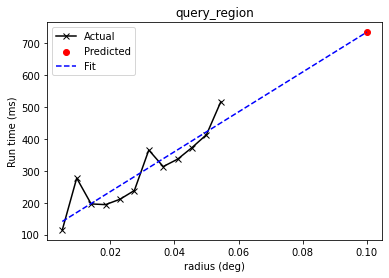

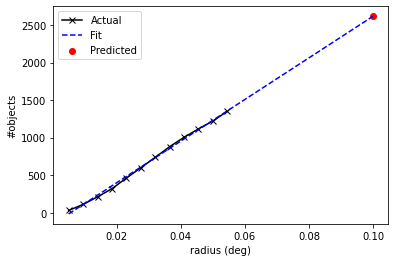

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    t_est, n_est = conesearch.predict_search(
        'http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&',
        c, 0.1 * u.degree, verbose=False, plot=True)

In [25]:
print('Predicted run time is', t_est, 'seconds')
print('Predicted number of rows is', n_est)

Predicted run time is 0.734802881413499 seconds
Predicted number of rows is 2617


Let's get the actual run time and number of rows to compare with the prediction above. This might take a while.

As you will see, the prediction is not spot on, but it's not too shabby (at least, not when we tried it!). Note that both predicted and actual run time results also depend on network latency and responsiveness of the service provider.

In [26]:
t_real, tab = conesearch.conesearch_timer(
    c, 0.1 * u.degree,
    catalog_db='http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&',
    verbose=False)

INFO: conesearch_timer took 0.6803531646728516 s on AVERAGE for 1 call(s). [astroquery.utils.timer]


In [27]:
print('Actual run time is', t_real, 'seconds')
print('Actual number of rows is', len(tab))

Actual run time is 0.6803531646728516 seconds
Actual number of rows is 4028
